In [1]:
from __future__ import division
from numpy import pi, linspace, sin, cos, exp, log, sqrt, dot
from numpy.linalg import norm
import numpy.random as rnd
import random


import numpy as np
import matplotlib.pyplot as plt
#import theano as T

%matplotlib inline

sigmoid = lambda x: 1/(1+np.exp(-x))

In [2]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

<h1> Write own neural network code </h1>

In [85]:
""" Multi Layer Perceptron"""


class multilayer_perceptron(object):
    
    

    
    def __init__(self,units_per_layer,activation='sigmoid',costF='quadratic'):
        self.num_layers = len(units_per_layer)
        self.biases = [np.random.randn(y, 1) for y in units_per_layer[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(units_per_layer[:-1], units_per_layer[1:])]

        if activation=='sigmoid':
            self.activation = lambda x: 1./(1.+np.exp(-x))
            self.activation_deriv = lambda x: sigmoid(x)*(1-sigmoid(x))
        else:
            raise ValueError
            
        if costF=='cross_entropy':
            self.costF = lambda a,y: 1/len(a) * np.sum(y*np.log(a) + (1-y)*np.log(1-a))
            self.get_output_delta = lambda a,y,z: (a-y)
        elif costF=='quadratic':
            self.costF = lambda a,y: 1/len(a) * np.sum(norm(x-y)**2)
            self.get_output_delta = lambda a,y,z: ((a-y)*
                                            self.activation_deriv(z))



    def forwardpass(self, a):
        """Return the output of the network if 'a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = self.activation(np.dot(w, a)+b)
        return a


   
            
    def backprop(self,network_input,target_activation):

            delta_cost_biass = [np.zeros(b.shape) for b in self.biases]
            delta_cost_weights = [np.zeros(w.shape) for w in self.weights]

            weighted_activations = []; 
            a = network_input
            activations = [a]
            "first perform the forward pass"
            for b, w in zip(self.biases, self.weights):
                #print 'a: %s, b: %s, c: %s' %(a.shape, b.shape, w.shape)
                z = np.dot(w, a)+b 
                weighted_activations.append(z)
                a = sigmoid(z)
                activations.append(a)

            "calculate the ouput errors"
            delta = self.get_output_delta(activations[-1],target_activation,weighted_activations[-1])
            delta0 = delta
            #print delta.shape
            
            
            delta_cost_biass[-1] = delta
            delta_cost_weights[-1] = np.dot(delta, activations[-2].T)
            d0 = np.dot(delta, activations[-2].T)
            #print activations[-2].shape
            #print d0.shape
            "propagate the errors back"
            #layer_errors = []
            #layer_errors[-1] = delta
            for l in xrange(2,self.num_layers):
                delta = np.dot(self.weights[-l+1].T,delta)*self.activation_deriv(weighted_activations[-l])
                delta_cost_biass[-l] = delta
                delta_cost_weights[-l] =  np.dot(delta, activations[-l-1].T)

            return delta_cost_weights, delta_cost_biass, d0
        
        
    def miniBatch_backprop(self,network_inputs,target_activation):

            #print network_inputs.shape[1]
            delta_cost_biass = [np.zeros(list(b.shape) + [network_inputs.shape[1]]) for b in self.biases]
            delta_cost_weights = [np.zeros(list(w.shape) + [target_activation.shape[1]]) for w in self.weights]
            weighted_activations = []; 
            a = network_inputs
            activations = [a]
            "first perform the forward pass"
            for b, w in zip(self.biases, self.weights):
                z = np.dot(w, a)+b 
                weighted_activations.append(z)
                a = sigmoid(z)
                activations.append(a)
                
                
            "calculate the ouput errors"
            delta = self.get_output_delta(activations[-1],target_activation,weighted_activations[-1])
            
            
            
            delta_cost_biass[-1] = np.array([delta.sum(axis=1)]).T
            delta_cost_weights[-1] = np.einsum('ik,jk->kij', delta, activations[-2]).sum(axis=0)


            for l in xrange(2,self.num_layers):
                delta = np.dot(self.weights[-l+1].T,delta)*self.activation_deriv(weighted_activations[-l])
                delta_cost_biass[-l] = np.array([delta.sum(axis=1)]).T
                delta_cost_weights[-l] =  np.einsum('ik,jk->kij', delta, activations[-l-1]).sum(axis=0)

            return delta_cost_weights, delta_cost_biass

        
    
    def minibatch_weight_update(self,mini_batch,eta):

        delta_cost_biass = [np.zeros(b.shape) for b in self.biases]
        delta_cost_weights = [np.zeros(w.shape) for w in self.weights]
        
        #recursive for calculating errors over training examples
        n_examples = len(mini_batch)
        
        
        x_data = np.squeeze(np.array([mini_batch[i][0] for i in range(n_examples)])).T
        y_data = np.squeeze(np.array([mini_batch[i][1] for i in range(n_examples)])).T
        

        delta_cost_weights, delta_cost_biass = self.miniBatch_backprop(x_data,y_data)
        
        #ars = []
        
        """for x, y in mini_batch:
            delta_w, delta_b,ar = self.backprop(x, y)
            ars.append(ar)
            delta_cost_biass = [nb+dnb for nb, dnb in zip(delta_cost_biass, delta_b)]
            delta_cost_weights = [nw+dnw for nw, dnw in zip(delta_cost_weights, delta_w)]
        
        """
        
        "Below the checks are working, as far as I can tell 15/02/2015"
        #print np.allclose(delta_cost_weights[0], delta_cost_weights_2[0])   #check weights
        #print print np.allclose(delta_cost_biass[0], delta_cost_biass_2[0])  #for checking bias 
        #print np.allclose(ar2[0][:,4],np.squeeze(np.array(ars[4][0])))    #for checking activations example=4
        #print np.allclose(np.squeeze(delta_cost_weights[1]),np.squeeze(delta_cost_weights_2[1]))  #for checking bias 
        #print np.allclose(np.squeeze(ar2),np.squeeze(np.array(ars)).T)  #for checking output error (i.e. delta) example=6

        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, delta_cost_weights)]
        #print b.shape, nb.shape
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, delta_cost_biass)]
    
    def stochastic_gradient_descent(self, training_data, epochs, mini_batch_size, eta,test_data=None):
        
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                #print [i.shape for i in self.biases]
                self.minibatch_weight_update(mini_batch, eta)
                #print 'ho'
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)
    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.forwardpass(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    
                
                
                

In [86]:
mlp = multilayer_perceptron([784, 30, 10],costF='quadratic')
mlp.stochastic_gradient_descent(training_data, 15, 10, 3.0, test_data=test_data)

Epoch 0: 9081 / 10000
Epoch 1: 9254 / 10000
Epoch 2: 9336 / 10000


KeyboardInterrupt: 

In [5]:
""" When doing the parallel processing, have delta.shape=(10, 10) activations[-2].shape=(30, 10)"""

' When doing the parallel processing, have delta.shape=(10, 10) activations[-2].shape=(30, 10)'

In [986]:
ttt = range(2)
print ttt[-1], ttt[-2]
#ttt[-1]

1 0


In [630]:

acts = randn(3,4,1)
print acts
print acts.T

[[[ 0.31739983]
  [ 0.45995428]
  [ 0.59991046]
  [-0.55894962]]

 [[ 0.51055908]
  [ 0.26796226]
  [-0.55077474]
  [-0.71627016]]

 [[-0.00587581]
  [-0.98922793]
  [-0.42314318]
  [ 0.27121335]]]
[[[ 0.31739983  0.51055908 -0.00587581]
  [ 0.45995428  0.26796226 -0.98922793]
  [ 0.59991046 -0.55077474 -0.42314318]
  [-0.55894962 -0.71627016  0.27121335]]]


In [665]:
from numpy.random import randn

dlt = randn(10,1)

acts = randn(30,1)

np.dot(dlt,acts.T).shape


print dlt.shape,acts.shape

(10, 1) (30, 1)


In [693]:
puy = np.array([np.arange(2)]).T
puy2 = np.array([np.arange(3)]).T

print puy, '\n'
print puy2.T 
np.dot(puy,puy2.T)
#print puy.shape, puy2.shape

[[0]
 [1]] 

[[0 1 2]]


array([[0, 0, 0],
       [0, 1, 2]])

In [720]:
np.einsum('ij->k',puy,puy2)

ValueError: fewer operands provided to einstein sum function than specified in the subscripts string

In [19]:

puy = np.arange(8000).reshape(20,400)
puy2 = np.arange(12000).reshape(30,400)




In [23]:
%%timeit

zz = np.zeros([400,20,30])

for i in range(400):
    zz[i,:,:] = np.dot(np.array([puy[:,i]]).T,
                np.array([puy2.T[i,:]]))




100 loops, best of 3: 4.59 ms per loop


In [22]:
%%timeit

np.einsum('ik,jk->kij', puy, puy2)

1000 loops, best of 3: 267 µs per loop


In [776]:
n_examples = len(training_data)
x_data = np.array([training_data[i][0] for i in range(n_examples)])
y_data = np.array([training_data[i][1] for i in range(n_examples)])

In [777]:
x_data = np.squeeze(x_data).T
x_data.shape[1]

50000

In [778]:
x_data[:,100].shape

(784,)

49


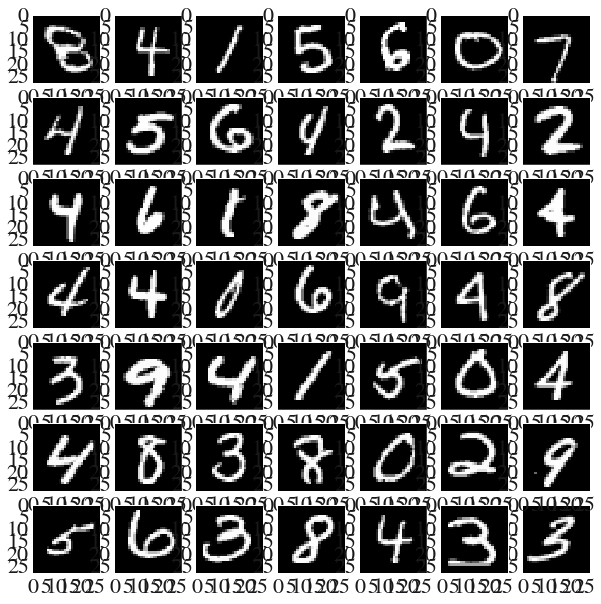

In [779]:
plt.figure(figsize=(10,10))


k = 0 
for i in range(1,8):
    for j in range(1,8):
        plt.subplot(7,7,k)
        plt.imshow(x_data[:,k].reshape(28,28),cmap='binary_r',interpolation='none')
        plt.grid()
        plt.yticks()
        k+= 1
print i*j

(784, 50000)

<h1> Reporgram Network outside the context of fucking-OOP bullshit<h1>

In [236]:
"Initialise the Network"

units_p_layer = [784, 30, 10]
num_layers = len(units_p_layer)
biases = [np.random.randn(y,1) for y in units_p_layer[1:]]
weights =  [np.random.randn(y, x) for x, y in zip(units_p_layer[:-1], units_p_layer[1:])]

activation = lambda x: 1./(1.+np.exp(-x))
activation_deriv = lambda x: sigmoid(x)*(1-sigmoid(x))

costF = lambda a,y: 1/len(a) * np.sum(norm(x-y)**2)

get_output_delta = lambda a,y,z: ((a-y)*  activation_deriv(z))

In [237]:
" Do stochastic minibatch-gradient descent for 1 epoch"

n = len(training_data)
mini_batch_size = 10

random.shuffle(training_data)

mini_batches = [ training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]


mini_batch = mini_batches[0]


Delta_cost_biass = [np.zeros(b.shape) for b in biases]
Delta_cost_weights = [np.zeros(w.shape) for w in weights]


n_examples = len(mini_batch)


#x_data = np.squeeze(np.array([training_data[i][0] for i in range(n_examples)])).T
#y_data = np.squeeze(np.array([training_data[i][1] for i in range(n_examples)])).T


In [292]:
ars= []


for network_input, target_activation in mini_batch:
    
    delta_cost_biass = [np.zeros(b.shape) for b in biases]
    delta_cost_weights = [np.zeros(w.shape) for w in weights]

    weighted_activations = []; 
    a = network_input
    activations = [a]
    "first perform the forward pass"
    for b, w in zip(biases, weights):
        #print 'a: %s, b: %s, c: %s' %(a.shape, b.shape, w.shape)
        z = np.dot(w, a)+b 
        weighted_activations.append(z)
        a = sigmoid(z)
        activations.append(a)

    ars.append(weighted_activations[0])

In [442]:
len(mini_batch[6][0])

784

In [ ]:
np.squeez

In [446]:
mini_batch = mini_batches[0]




n_examples = len(mini_batch)

x_data = np.squeeze(np.array([mini_batch[i][0] for i in range(n_examples)]))
y_data = np.array([mini_batch[i][1] for i in range(n_examples)])

In [451]:
kk = 6
print x_data[kk,:].shape, np.squeeze(mini_batch[kk][0]).shape
print np.isclose(x_data[kk,:],np.squeeze(mini_batch[kk-1][0])).all()

(784,) (784,)
False


In [302]:
zs_serial = np.array([ars[i][:,0] for i in range(len(ars))])

(784,) (784, 1)
False


In [294]:
print x_data.shape
a = x_data
zs = []
for b, w in zip(biases, weights):
        #print 'a: %s, b: %s, c: %s' %(a.shape, b.shape, w.shape)
        z = np.dot(w,a)+b 
        zs.append(z)
        print z.shape
        weighted_activations.append(z)
        a = activation(z)
        print a.shape
        activations.append(a)

(784, 10)
(30, 10)
(30, 10)
(10, 10)
(10, 10)


In [372]:
np.isclose(np.dot(weights[0],x_data[:,6]),np.dot(weights[0],x_data)[:,6]).all()

True

In [309]:
np.dot(weights[0],x_data)[:,0]

array([ -2.85733504, -10.95558156, -10.00725864,  -5.77073851,
        11.79546477,   5.0275419 , -11.27519516,  13.19007087,
         8.39289714,   5.48909615, -14.74193554,   3.28699989,
        -1.87634995,  -5.03920653,  -3.25347905,   1.2367262 ,
        18.49627858,  -8.60970004,  -2.10982594,   5.66897992,
        -5.83039227,   9.22313255,  12.50644141,   3.98346472,
        -8.45147191,   0.41202166,  -2.31740025,  12.05791539,
         2.05799706,  -0.6862063 ])

In [ ]:
            
    def backprop(self,network_input,target_activation):

            delta_cost_biass = [np.zeros(b.shape) for b in self.biases]
            delta_cost_weights = [np.zeros(w.shape) for w in self.weights]

            weighted_activations = []; 
            a = network_input
            activations = [a]
            "first perform the forward pass"
            for b, w in zip(self.biases, self.weights):
                #print 'a: %s, b: %s, c: %s' %(a.shape, b.shape, w.shape)
                z = np.dot(w, a)+b 
                weighted_activations.append(z)
                a = sigmoid(z)
                activations.append(a)

            "calculate the ouput errors"
            delta = self.get_output_delta(activations[-1],target_activation,weighted_activations[-1])

            
            
            delta_cost_biass[-1] = delta
            delta_cost_weights[-1] = np.dot(delta, activations[-2].transpose())
            "propagate the errors back"
            #layer_errors = []
            #layer_errors[-1] = delta
            for l in xrange(2,self.num_layers):
                delta = np.dot(self.weights[-l+1].T,delta)*self.activation_deriv(weighted_activations[-l])
                delta_cost_biass[-l] = delta
                delta_cost_weights[-l] =  np.dot(delta, activations[-l-1].T)

            return delta_cost_weights, delta_cost_biass, weighted_activations

In [93]:
art  = np.array([np.random.randn(10) for i in range(2)]).T

In [98]:
print w[0].shape, art.shape

(10,) (10, 2)


In [101]:
sigmoid(np.dot(w[0],art))

array([ 0.98083452,  0.00600646])

In [103]:
print sigmoid(np.dot(w[0],art[:,0])), sigmoid(np.dot(w[0],art[:,1]))

0.980834518292 0.00600645986615


In [ ]:
#print network_inputs.shape[1]
delta_cost_biass = [np.zeros(list(b.shape) + [network_inputs.shape[1]]) for b in self.biases]
delta_cost_weights = [np.zeros(list(w.shape) + [target_activation.shape[1]]) for w in self.weights]
weighted_activations = []; 
a = network_inputs
activations = [a]
"first perform the forward pass"
for b, w in zip(self.biases, self.weights):
    #print 'a: %s, b: %s, c: %s' %(a.shape, b.shape, w.shape)
    z = np.dot(w, a)+b 
    weighted_activations.append(z)
    a = sigmoid(z)
    activations.append(a)



In [773]:
%%timeit

if 1<0:
    o = np.sqrt(7345**62)
    print 'ho'
else:
    pass

10000000 loops, best of 3: 45.3 ns per loop
